In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from random import sample

In [2]:
df = pd.read_csv("trajectory.csv")
df.columns = ["time", "vehicle_id", "edge", "lane", "x", "y","toremove"]
del df['toremove']
df.head() # df now holds the data

,time,vehicle_id,edge,lane,x,y
0,3,flow_0.0,gneE0,gneE0_1,6.125964,-11.2
1,4,flow_0.0,gneE0,gneE0_1,7.173879,-11.2
2,5,flow_0.0,gneE0,gneE0_1,8.238620,-11.2
3,5,flow_0.1,gneE0,gneE0_3,5.100000,-4.8
4,6,flow_0.0,gneE0,gneE0_1,9.320816,-11.2


In [3]:
# Obtain all the traces of a particular edge, here gneE0 is chosen
# df_edge = df[(df['vehicle_id'].isin(selected_vehicle_ids)) & (df['edge'] == 'gneE0')]
df_edge = df[df['edge'] == 'gneE0']
vehicle_ids_on_edge = df_edge['vehicle_id'].unique().tolist()
selected_vehicle_ids = sample(vehicle_ids_on_edge, 200) # get 100 vehicle traces
df_mini = df_edge[df_edge['vehicle_id'].isin(selected_vehicle_ids)]
df_mini.head()

,time,vehicle_id,edge,lane,x,y
3,5,flow_0.1,gneE0,gneE0_3,5.100000,-4.8
5,6,flow_0.1,gneE0,gneE0_3,6.123400,-4.8
7,7,flow_0.1,gneE0,gneE0_3,7.161216,-4.8
9,8,flow_0.1,gneE0,gneE0_3,8.223547,-4.8
11,9,flow_0.1,gneE0,gneE0_3,9.304487,-4.8


Max length of trajectory x: 489
Max length of trajectory y: 489


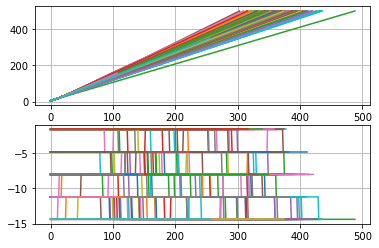

In [4]:
fig = plt.figure()
plt_x = fig.add_subplot(2,1,1)
plt_x.grid(True)
plt_y = fig.add_subplot(2,1,2)
plt_y.grid(True)
max_length_y = 0
max_length_x = 0

for veh_id in selected_vehicle_ids:
    df_of_veh = df_mini[df_mini['vehicle_id'] == veh_id]
    t_vec = df_of_veh['time'].to_numpy()
    t_vec = t_vec - t_vec[0]
    x_vec = df_of_veh['x'].to_numpy()
    y_vec = df_of_veh['y'].to_numpy()
    if x_vec.shape[0] > max_length_x:
        max_length_x = x_vec.shape[0]
    if y_vec.shape[0] > max_length_y:
        max_length_y = y_vec.shape[0]
    plt_x.plot(t_vec, x_vec)
    plt_y.plot(t_vec, y_vec)

print('Max length of trajectory x: {:d}'.format(max_length_x))
print('Max length of trajectory y: {:d}'.format(max_length_y))

In [5]:
# Export the data to CSV to be processed with unsupervised segmentation in R
df_mini[['vehicle_id','time','x','y']].to_csv('edge_trajectories.csv')